<div class="alert alert-block alert-info">
    
# TOC<a class="anchor"><a id='toc'></a></b><br>
* [<font color='#E8800A'>Naive Bayes</font>](#first-bullet) <br>
- [<font color='#E8800A'>Logistic Regression</font>](#second-bullet)<br>
- [<font color='#E8800A'>KNN</font>](#third-bullet)<br>
- [<font color='#E8800A'>Support Vector Machines</font>](#fourth-bullet)<br>
    
</div>

In [1]:
import pandas as pd
import numpy as np
import os
import re


import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, make_scorer

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier


%pip install boruta
from boruta import BorutaPy

%pip install imblearn
from imblearn.over_sampling import SMOTE

%pip install pandas_profiling
from pandas_profiling import ProfileReport


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\doris\anaconda3\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\doris\anaconda3\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.



You should consider upgrading via the 'C:\Users\doris\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
# definitions 
datain_path = 'data/'

explorations_path = 'explorations/'
if not os.path.exists(explorations_path): 
    os.makedirs(explorations_path)

In [3]:
datasets = {
    'train': 'Train.xlsx',
    'test':'Test.xlsx', 
    'both': {
        'train': 'Train.xlsx',   
        'test':'Test.xlsx',
    } 
}

#datasets = pd.DataFrame(datasets, columns=['name', 'path']).set_index('name')

dataset_name = 'both'


In [4]:
if dataset_name == 'both': 
    data = pd.DataFrame()
    for dataset_path in datasets[dataset_name].values(): 
        tmp = pd.read_excel(os.path.join(datain_path, dataset_path))
        data = pd.concat([data, tmp])

else:    
    dataset_path = datasets[dataset_name]
    data = pd.read_excel(os.path.join(datain_path, dataset_path))
data.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1.0
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1.0
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1.0
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1.0
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1.0


In [5]:
data.isna().sum()

CITIZEN_ID                    0
Name                          0
Birthday                      0
Native Continent              0
Marital Status                0
Lives with                    0
Base Area                     0
Education Level               0
Years of Education            0
Employment Sector             0
Role                          0
Working Hours per week        0
Money Received                0
Ticket Price                  0
Income                    10100
dtype: int64

# Explorations

## profile report

profile = ProfileReport(
    data,
    title='Raw data',
    minimal=False, 
    correlations={
    "pearson": {"calculate": True},
    "spearman": {"calculate": False},
    "kendall": {"calculate": False},
    "phi_k": {"calculate": False},
    "cramers": {"calculate": False},
    }
)
profile.to_file(os.path.join(explorations_path, 'profile_data_raw.html'))


In [6]:
n_feature=10

def get_feature_imp_by_expl(data, base_col, n_feature=n_feature): 
    
    # make sure every combination of levels exist, fill with 0 if no obs
    base = data[base_col].unique()
    Income = [0, 1]
    idx = pd.MultiIndex.from_product(
        [base, Income],
        names=[base_col, 'Income']
    )

    pd1 = pd.DataFrame(index=idx)
    

    a = data.groupby([base_col, 'Income']).size().to_frame().rename(columns={0:'nobs'})
    
    a = pd.concat([pd1, a], axis=1)
    a.loc[a.nobs.isna(), 'nobs'] = 0
    
    a['nobs_rel'] = a.groupby(level=base_col).transform(lambda x: x / (x[0] + x[1]))
    value_cols = a.columns.to_list()
    a.reset_index(inplace=True)
    
    # top Features by nobs: 
    topFeat = data.groupby(base_col).size().to_frame().rename(columns={0:'nobs'})\
        .sort_values('nobs', ascending=False).iloc[0:n_feature,:]\
        .index.to_list()
    
    a.sort_values(['nobs', base_col], ascending=False, inplace=True)
    
    #print('len(topFeat)', len(topFeat))
    #print('len(a)', len(a))
    #print('n_feature', n_feature)
    #print('a[base_col].nunique()', a[base_col].nunique())

    if len(topFeat) < a[base_col].nunique(): 
        print(f'***Features Filtered to top_{n_feature} by nobs!***')
    #print(a[base_col].nunique())

    a = a.loc[a[base_col].isin(topFeat),:]
    return a, value_cols

def plot_feature_imp_by_expl(data, base_col): 
    
    a, value_cols = get_feature_imp_by_expl(data, base_col)
    n_plots = len(value_cols) + 1

    fig, ax = plt.subplots(ncols = n_plots  , figsize=(20,7), gridspec_kw={'width_ratios': [3,3,1]})
    for i, col in enumerate(value_cols): 
        sns.barplot(data=a, x=base_col, y=col, hue='Income', ax=ax[i])#.set_title(col) # [0:10]
        ax[i].tick_params(labelrotation=45)

    sns.countplot(data=data, x='Income', ax=ax[n_plots-1])
    plt.show()
    
def get_target_ratio(data):  
    a = data.groupby(['Income']).size().to_frame().rename(columns={0:'nobs'})
    a['nobs_rel'] = a.transform(lambda x: x / (x[0] + x[1]))
    value_cols = a.columns.to_list()
    a.reset_index(inplace=True)
    return a.loc[a.Income == 1, 'nobs_rel'].to_list()[0]


def get_feature_imp_by_target_ratio(data, base_col, weighted=False): 

    target_ratio = get_target_ratio(data)
    target_ratio
                                            
    a, _ = get_feature_imp_by_expl(data, base_col, n_feature=100)
    
    #########
    nObsPerFeatClass =  data.groupby([base_col]).size().to_frame().rename(columns={0:'nobs'})
                           

    ratio_per_level = a.loc[a.Income == 1, [base_col,'nobs_rel']]\
        .set_index(base_col)\
        .rename(columns={'nobs_rel':'class1_ratio'})

    ratio_per_level = pd.concat([ratio_per_level, nObsPerFeatClass], axis=1)
    #min_max_scaler_obs = MinMaxScaler()
    ratio_per_level['nobs_rel'] = ratio_per_level.nobs / sum(ratio_per_level.nobs)


    
    ratio_per_level['diff_to_target'] = ratio_per_level['class1_ratio'] - target_ratio
    ratio_per_level['diff_to_target_dir'] = ['neg' if obs < 0 else 'pos' for obs in ratio_per_level['diff_to_target']]
    
    if weighted: 
        weights = np.power(ratio_per_level['nobs_rel'], 1./3)
    else: 
        weights = 1
        
    ratio_per_level['diff_to_target_abs'] = abs(ratio_per_level['diff_to_target']) * weights
    
    #print(ratio_per_level)

    ratio_per_level.sort_values('diff_to_target_abs', ascending=False, inplace=True)
    ratio_per_level['diff_to_target_abs_cumsum'] = ratio_per_level.diff_to_target_abs.cumsum()
    ratio_per_level


    x = ratio_per_level['diff_to_target_abs_cumsum'].values.reshape(-1, 1) #df.values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    ratio_per_level['diff_to_target_abs_cumsum_scaled'] = min_max_scaler.fit_transform(x)

    print('TargetClass1_ratio', target_ratio)
    print(ratio_per_level[['diff_to_target_dir', 'diff_to_target_abs']])

    return ratio_per_level


def plot_feature_imp_by_target_ratio(data, base_col, weighted=False): 

    r = get_feature_imp_by_target_ratio(data, base_col, weighted)

    sns.lineplot(data=r, y=r.index, x='diff_to_target_abs_cumsum_scaled')
    plt.show()
    
    
def plot_feature_imp_by_tree(data, base_col, n_feature=n_feature): 
    # prepare
    onehot = OneHotEncoder()
    X_train_cat = data.loc[:,[base_col]]
    #X_train_cat = data[base_col]

    X_train_onehot = onehot.fit_transform(X_train_cat)
    X_train_onehot_df = pd.DataFrame(X_train_onehot.toarray(), columns=onehot.get_feature_names())
    X_train_onehot_df

    X_train_onehot_df = pd.get_dummies(data[base_col], prefix=base_col)

    # train
    dt_gini = DecisionTreeClassifier(random_state = 1)
    X_train = X_train_onehot_df#.drop(columns=['x0_Africa','x0_Europe', 'x0_Oceania'])
    y_train = data.Income


    dt_gini.fit(X_train, y_train) # data[base_col]
    print('Score:', dt_gini.score(X_train, y_train))

    #dt_gini.feature_importances_
    #tree.plot_tree(dt_gini)

    #plt.barh(onehot.get_feature_names(), dt_gini.feature_importances_)

    #print(dt_gini.feature_importances_)
    sorted_idx = dt_gini.feature_importances_.argsort()#[0:10]
    plotdata = pd.DataFrame({
        'Feature': X_train.columns[sorted_idx], 
        'Importance': dt_gini.feature_importances_[sorted_idx]}).sort_values('Importance', ascending=False)
    #plt.barh()
    #print(plotdata)
    sns.barplot(data=plotdata.iloc[0:n_feature,:], x='Importance', y='Feature')
    plt.xlabel("Feature Importance")
    
    plt.show()

    
def plot_feature_imp(data, base_col, force_barplot=True, weighted=False): 
    print('Class distributions')
    if (data[base_col].nunique() < 6) | force_barplot:
        n_plots = 2
        plot_feature_imp_by_expl(data, base_col)
    else: 
        n_plots = 1
        
    print('\nElbow')        
    plot_feature_imp_by_target_ratio(data, base_col, weighted)
    
    print('\nDecision Tree')
    plot_feature_imp_by_tree(data, base_col)
    
def levels_equal(data, base_col):
    train_levels = np.sort(data.loc[~data.Income.isna(), base_col].unique()).tolist()
    test_levels = np.sort(data.loc[data.Income.isna(), base_col].unique()).tolist()
    
    equal = train_levels == test_levels
    if not equal: 
        test_levels_df = pd.DataFrame({
            'test_levels': test_levels
        })

        train_levels_df = pd.DataFrame({
            'train_levels': train_levels
        })

        compare = pd.merge(left=train_levels_df, right=test_levels_df, how='outer', left_on='train_levels', right_on='test_levels')
        print(compare.loc[(compare.train_levels.isna()) | (compare.test_levels.isna()) ])

        print(f'Levels of "{base_col}" differ between test and train set')
        #raise ValueError(f'Levels of "{base_col}" differ between test and train set')
    else: 
        print('Levels ok')
    return None


In [7]:
# init 
cols_to_drop = []
cols_to_onehot = []
cols_numeric = []
cols_bool = []



# prep
pred_config = {
    'cardinality': 'original' # low, medium, high, original
} 

cardinality = pred_config['cardinality']
print('cardinality:', cardinality)

error_log = {'cleaning': []}


cardinality: original


Mr.     21749
Mrs.     5993
Miss     4758
Name: 0, dtype: int64


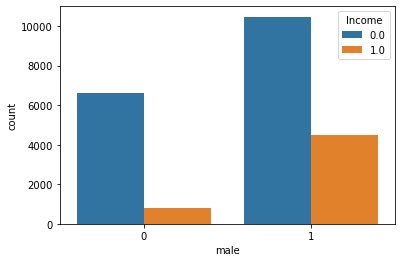

In [8]:
# extract gender from name?!
base_col = 'Name'
target_col = 'male'

salutation = data[base_col].str.split(' ', n=1, expand=True)[0]
if salutation.nunique() != 3: 
    raise ValueError('Unexpected levels of salutation')
    
print(salutation.value_counts())

#gender = ['male' if s == 'Mr.' else 'female' for s in salutation]
#data['gender'] = gender

male = [1 if s == 'Mr.' else 0 if s in ['Mrs.', 'Miss'] else np.nan for s in salutation]
data[target_col] = male

if data.male.isna().sum() > 0: 
    raise Warning('NAs instroduced')


sns.countplot(data=data, hue=data.Income, x=target_col)#.set_title(col)
plt.show()
    
cols_to_drop.append(base_col)
cols_bool.append(target_col)


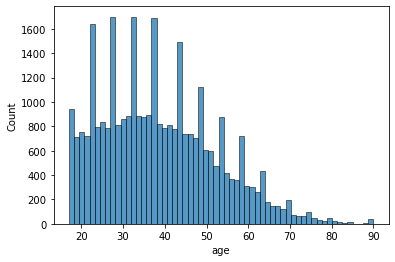

Min age: 17.0


In [9]:
# Compute age from Birthday

# clean whitespaces
data.Birthday = data.Birthday.str.replace(' ', '')
# define date format
dob_format = '%B%d,%Y'

# transform Birthday to datetime, catching the leap year error 

## helper fct to subtract one day from datetime if error occurs
def subone(obj):
    val = int(obj.group(0))
    return str(val-1)

## init and loop over dates
dob = []
warn_log = []
for i, d in enumerate(data.Birthday): 
    try: 
        dob.append(datetime.strptime(d, dob_format).date())

    except ValueError as e: 
        if str(e) == 'day is out of range for month': 
            dt = datetime.strptime(re.sub('\d{1,2}', subone, d, count=1), dob_format).date()
            warn_log.append((d, dt))
            dob.append(dt)
        else: 
            raise NotImplementedError('Do not know how to deal with that error!')
            dt = np.nan
            warn_log.append((d, dt))
            dob.append(dt)
        
# add age column 
data['age'] = [np.floor((datetime.strptime('2048-12-31', '%Y-%m-%d').date() - d).days / 365.2425) for d in dob]

# inspect
sns.histplot(data, x='age')
plt.show()
print('Min age:' , min(data.age))

# drop date col 
cols_to_drop.append('Birthday')
cols_numeric.append('age')


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32500 entries, 0 to 10099
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CITIZEN_ID              32500 non-null  int64  
 1   Name                    32500 non-null  object 
 2   Birthday                32500 non-null  object 
 3   Native Continent        32500 non-null  object 
 4   Marital Status          32500 non-null  object 
 5   Lives with              32500 non-null  object 
 6   Base Area               32500 non-null  object 
 7   Education Level         32500 non-null  object 
 8   Years of Education      32500 non-null  int64  
 9   Employment Sector       32500 non-null  object 
 10  Role                    32500 non-null  object 
 11  Working Hours per week  32500 non-null  int64  
 12  Money Received          32500 non-null  int64  
 13  Ticket Price            32500 non-null  int64  
 14  Income                  22400 non-null

In [11]:
data.loc[~data.Income.isna()]

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income,male,age
0,12486,Mr. Adam Glover,"July1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1.0,1,45.0
1,12487,Mr. Cameron McDonald,"January25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1.0,1,42.0
2,12488,Mr. Keith Davidson,"May10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1.0,1,39.0
3,12489,Mr. Alexander Gill,"March25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1.0,1,63.0
4,12490,Mr. Neil Piper,"May29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1.0,1,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,34881,Mrs. Lisa Alsop,"March15,2023",Europe,Divorced,Children,Northbury,Professional School,12,Private Sector - Services,Cleaners & Handlers,40,0,0,0.0,0,25.0
22396,34882,Mr. Julian Coleman,"March7,2025",Europe,Single,Children,Northbury,Professional School,12,Private Sector - Services,Other services,35,0,0,0.0,1,23.0
22397,34883,Miss Amelia Walker,"July20,2022",Europe,Single,Other Family,Northbury,Masters,17,Public Sector - Others,Professor,40,2674,0,0.0,0,26.0
22398,34884,Mr. Justin Sutherland,"June11,2011",Europe,Single,Other Family,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Repair & constructions,90,0,0,1.0,1,37.0


Class distributions


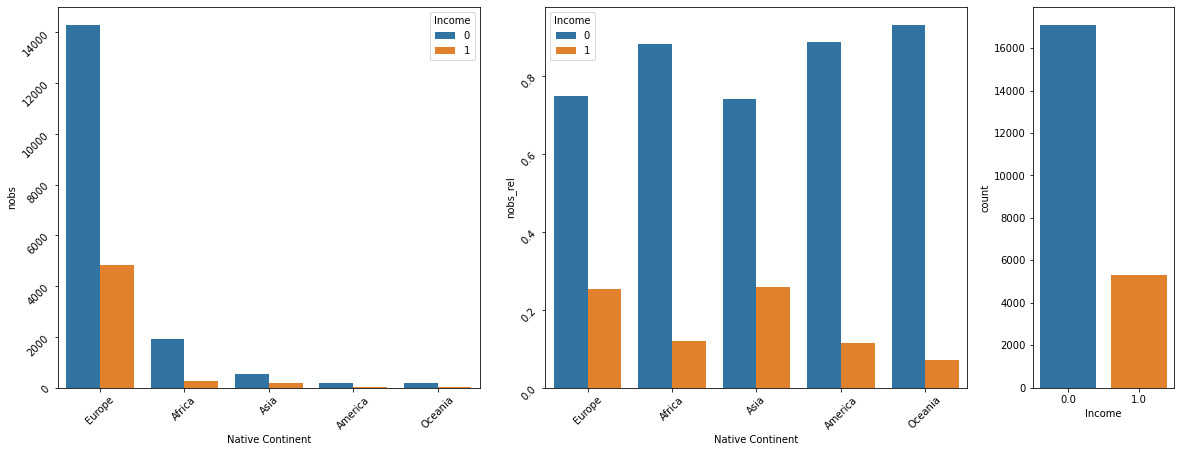


Elbow
TargetClass1_ratio 0.2370982142857143
        diff_to_target_dir  diff_to_target_abs
Oceania                neg            0.166446
America                neg            0.122943
Africa                 neg            0.118214
Asia                   pos            0.021843
Europe                 pos            0.015740


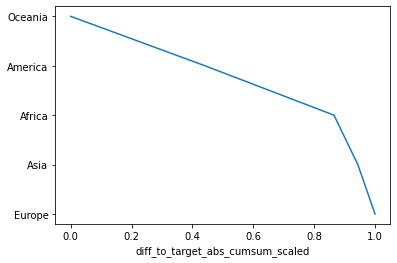


Decision Tree
Score: 0.7629017857142857


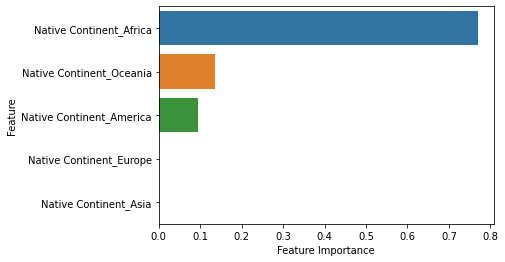

Levels ok


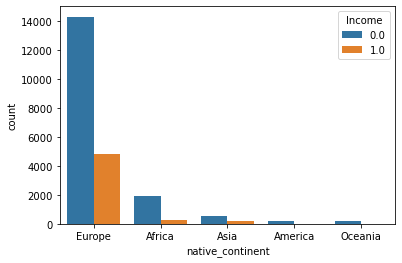

In [12]:
# 'Native Continent' to bin 
base_col = 'Native Continent'
#sns.countplot(data=data, hue=data.Income, x=base_col)#.set_title(col)
#plt.show()

plot_feature_imp(data.loc[~data.Income.isna()], base_col, weighted=False)
levels_equal(data, base_col)

#low, medium, high, original
try: 
    if cardinality in ['low', 'medium']:
        target_col = 'from_europe_or_asia'
        #data['from_europe'] = [1 if a == 'Europe' else 0 for a in data[base_col]]
        data[target_col] = [1 if a in ['Europe', 'Asia'] else 0 for a in data[base_col]]
        cols_bool.append(target_col)
    elif cardinality == 'original':
        target_col = 'native_continent'
        data[target_col] = data[base_col]
        cols_to_onehot.append(target_col)
    else: 
        raise NotImplementedError(f'Can not interpret cardinality "{cardinality}" for base feature "{base_col}"!')
except Exception as e:
    error_log['cleaning'].append(e)
    raise Warning(e)
    

sns.countplot(data=data, x=target_col, hue='Income')
plt.show()

cols_to_drop.append(base_col)



Class distributions


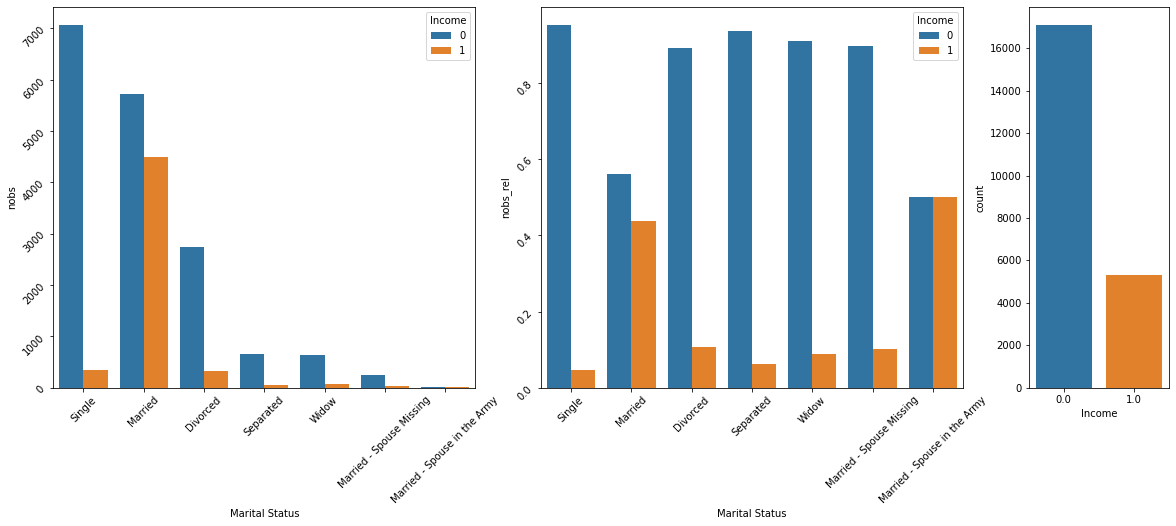


Elbow
TargetClass1_ratio 0.2370982142857143
                             diff_to_target_dir  diff_to_target_abs
Married - Spouse in the Army                pos            0.262902
Married                                     pos            0.202084
Single                                      neg            0.189364
Separated                                   neg            0.174151
Widow                                       neg            0.148018
Married - Spouse Missing                    neg            0.134986
Divorced                                    neg            0.130653


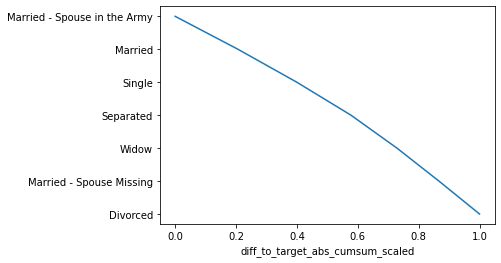


Decision Tree
Score: 0.7629017857142857


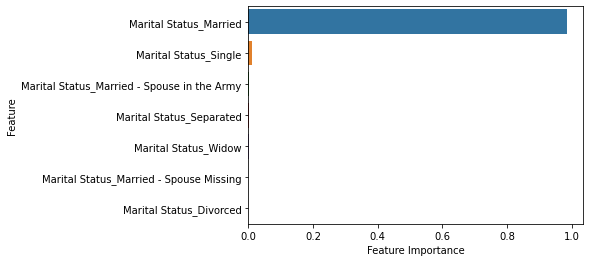

Levels ok


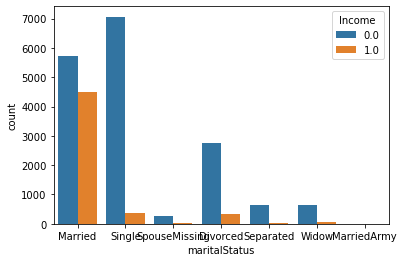

In [13]:
# Marital Status
base_col = 'Marital Status'
#target_col = 'marital_status'

data[base_col].value_counts()

plot_feature_imp(data.loc[~data.Income.isna()], base_col, weighted=False)
levels_equal(data, base_col)

try: 
    if cardinality == 'low': 
        target_col = 'maritalStatus_married'
        data[target_col] = [1 if a in ['Married', 'Married - Spouse in the Army'] else 0 for a in data[base_col]]
        cols_bool.append(target_col)
        
    elif cardinality == 'medium': 
        target_col = 'maritalStatus'
        mapping = {
            'Married':'Married',
            'Single':'Single',
            'Divorced':'Divorced',
            'Separated':'Separated',
            'Widow':'Widow',
            'Married - Spouse Missing':'SpouseMissing',
            'Married - Spouse in the Army':'Married'
        }

        data[target_col] = data[base_col].map(mapping)
        cols_to_onehot.append(target_col)
        
    elif cardinality == 'original': 
        target_col = 'maritalStatus'
        mapping = {
            'Married':'Married',
            'Single':'Single',
            'Divorced':'Divorced',
            'Separated':'Separated',
            'Widow':'Widow',
            'Married - Spouse Missing':'SpouseMissing',
            'Married - Spouse in the Army':'MarriedArmy'
        }

        data[target_col] = data[base_col].map(mapping)
        cols_to_onehot.append(target_col)

    else: 
        raise NotImplementedError(f'Can not interpret cardinality "{cardinality}" for base feature "{base_col}"!')
except Exception as e:
    error_log['cleaning'].append(e)
    raise Warning(e)
    
    
#sns.countplot(data=data, x=target_col)
sns.countplot(data=data, x=target_col, hue='Income')
plt.show()

cols_to_drop.append(base_col)


Wife               13171
Other Family        8286
Children            5059
Alone               3439
Husband             1564
Other relatives      981
Name: Lives with, dtype: int64
Class distributions


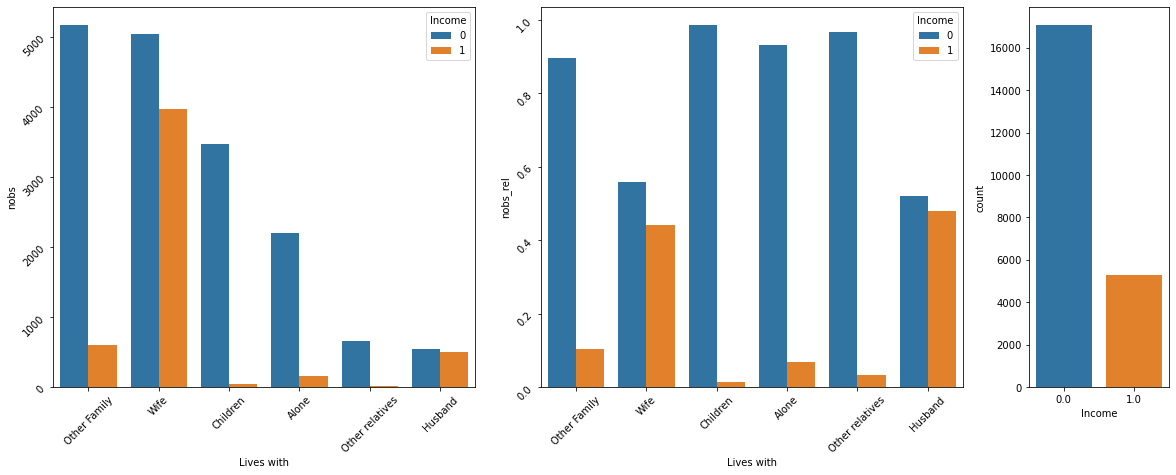


Elbow
TargetClass1_ratio 0.2370982142857143
                diff_to_target_dir  diff_to_target_abs
Husband                        pos            0.243359
Children                       neg            0.223458
Wife                           pos            0.203536
Other relatives                neg            0.203324
Alone                          neg            0.168936
Other Family                   neg            0.132546


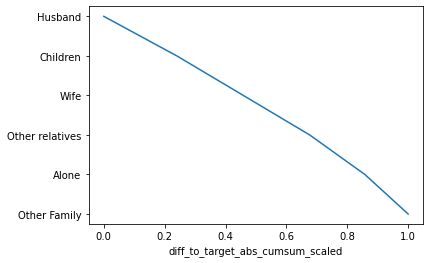


Decision Tree
Score: 0.7629017857142857


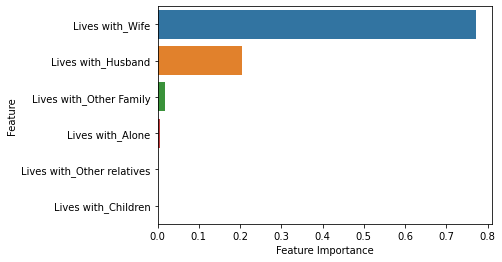

Levels ok
{'Wife': 'Wife', 'Other Family': 'Family', 'Children': 'Children', 'Alone': 'Alone', 'Husband': 'Husband', 'Other relatives': 'Other'}


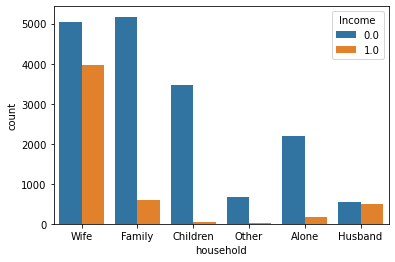

In [14]:
# Lives with
base_col = 'Lives with'
print(data[base_col].value_counts())

plot_feature_imp(data.loc[~data.Income.isna()], base_col, weighted=False)
levels_equal(data, base_col)

try: 
    if(cardinality == 'low'): 
        target_col = 'household_livesWithPartner'
        data[target_col] = [1 if a in ['Wife', 'Husband'] else 0 for a in data[base_col]]
        cols_bool.append(target_col)
    elif(cardinality == 'medium'): 
        target_col = 'household'
        mapping = {
            'Wife': 'Partner',
            'Other Family': 'Family',
            'Children': 'Children',
            'Alone': 'Alone',
            'Husband': 'Partner',
            'Other relatives': 'Family'
        }

        print(mapping)

        data[target_col] = data[base_col].map(mapping)
        cols_to_onehot.append(target_col)
    elif(cardinality == 'original'): 
        target_col = 'household'
        mapping = {
            'Wife': 'Wife',
            'Other Family': 'Family',
            'Children': 'Children',
            'Alone': 'Alone',
            'Husband': 'Husband',
            'Other relatives': 'Other'
        }

        print(mapping)

        data[target_col] = data[base_col].map(mapping)
        cols_to_onehot.append(target_col)
    else: 
        raise NotImplementedError(f'Can not interpret cardinality "{cardinality}" for base feature "{base_col}"!')
except Exception as e:
    error_log['cleaning'].append(e)
    raise Warning(e)

sns.countplot(data=data, x=target_col, hue='Income')
plt.show()

cols_to_drop.append(base_col)


Class distributions
***Features Filtered to top_10 by nobs!***


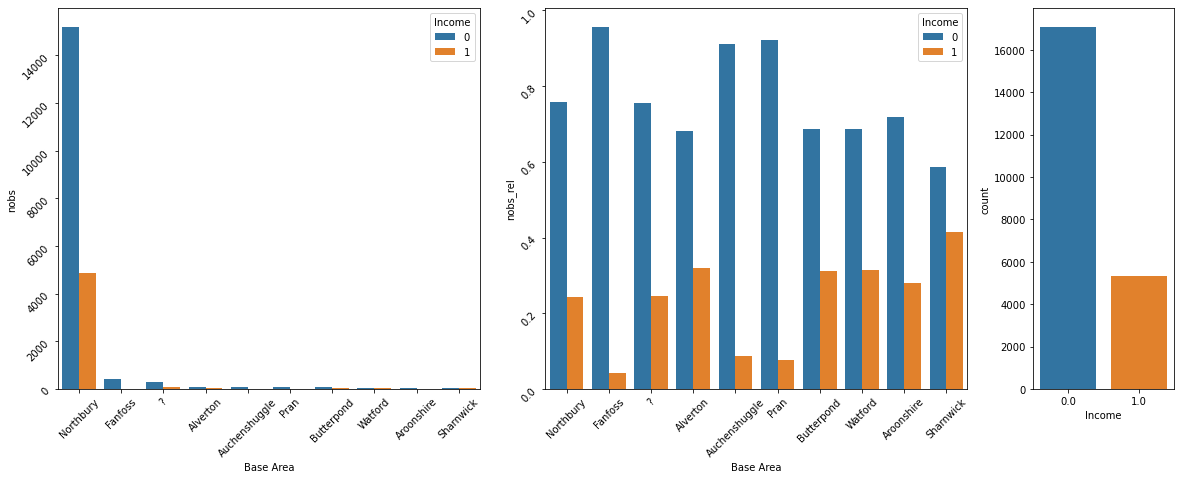


Elbow
TargetClass1_ratio 0.2370982142857143
              diff_to_target_dir  diff_to_target_abs
Ironforge                    neg            0.237098
Woodpine                     neg            0.237098
Mensfield                    neg            0.237098
Kald                         pos            0.236586
Bellmoral                    neg            0.212098
Cherrytown                   neg            0.197883
Fanfoss                      neg            0.194209
Aberuthven                   neg            0.193620
King's Watch                 neg            0.191644
Sharnwick                    pos            0.177188
Willesden                    neg            0.174598
Laenteglos                   pos            0.169152
Knife's Edge                 pos            0.168307
Lanercost                    neg            0.160175
Pran                         neg            0.159176
Laewaes                      neg            0.157733
Auchenshuggle                neg            0.149598
E

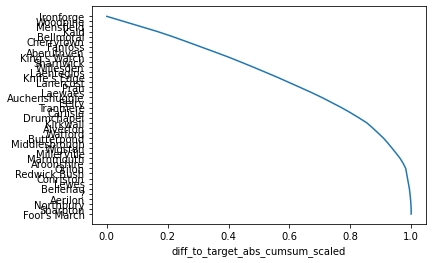


Decision Tree
Score: 0.7629017857142857


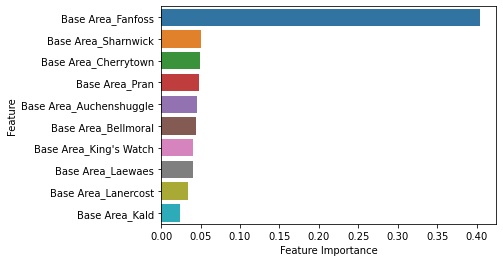

   train_levels test_levels
9      Carlisle         NaN
16    Ironforge         NaN
Levels of "Base Area" differ between test and train set


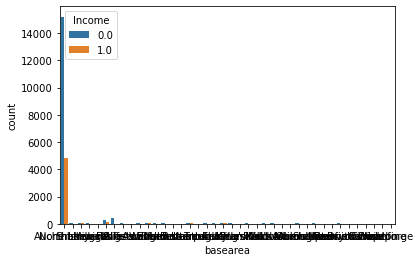

In [15]:
# 'Base Area' to bin 
base_col = 'Base Area'

plot_feature_imp(data.loc[~data.Income.isna()], base_col, weighted=False)
levels_equal(data, base_col)

try: 
    if cardinality == 'low': 
        target_col = 'basearea_fanfoss' # basearea_northbury
        target_val = 'Fanfoss'
        target_col_alt = 'basearea_northbury'
        target_val_alt = 'Northbury'

        print('\nResult:')
        data[target_col] = [1 if a == target_val else 0 for a in data[base_col]]

        print('\nAlternative result:')
        test = data[['Income', base_col]].copy()
        test[target_col_alt] = [1 if a == target_val_alt else 0 for a in test[base_col]]
        sns.countplot(data=test, x=target_col_alt, hue='Income')
        plt.show()
        cols_bool.append(target_col)
    elif cardinality == 'medium':
        target_col = 'basearea'
        data[target_col] = [
            target_val if a == target_val 
            else target_val_alt if a == target_val_alt 
            else 'Rest' for a in data[base_col]]
        cols_to_onehot.append(target_col)

    elif cardinality == 'original':
        target_col = 'basearea'
        data[target_col] = data[base_col]
        cols_to_onehot.append(target_col)
    else: 
        raise NotImplementedError(f'Can not interpret cardinality "{cardinality}" for base feature "{base_col}"!')
except Exception as e:
    error_log['cleaning'].append(e)
    raise Warning(e)

    
sns.countplot(data=data, x=target_col, hue='Income')
plt.show()

cols_to_drop.append(base_col)

Index(['CITIZEN_ID', 'Name', 'Birthday', 'Native Continent', 'Marital Status',
       'Lives with', 'Base Area', 'Education Level', 'Years of Education',
       'Employment Sector', 'Role', 'Working Hours per week', 'Money Received',
       'Ticket Price', 'Income', 'male', 'age', 'native_continent',
       'maritalStatus', 'household', 'basearea'],
      dtype='object')
Class distributions
***Features Filtered to top_10 by nobs!***


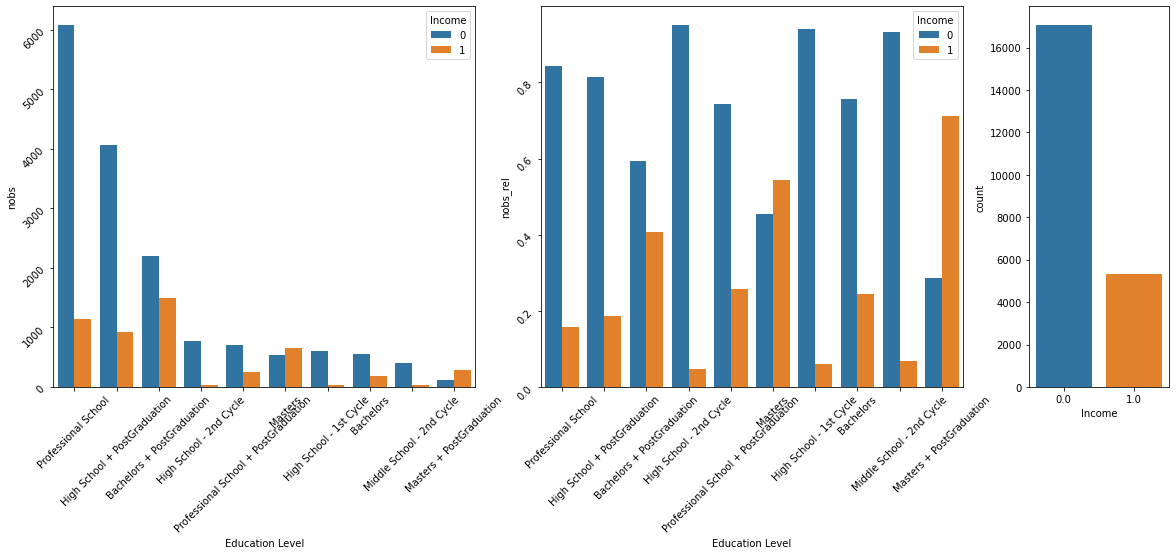


Elbow
TargetClass1_ratio 0.2370982142857143
                                     diff_to_target_dir  diff_to_target_abs
PhD                                                 pos            0.503386
Masters + PostGraduation                            pos            0.475748
Masters                                             pos            0.307747
Preschool                                           neg            0.237098
Primary School                                      neg            0.196115
Middle School - 1st Cycle                           neg            0.194904
High School - 2nd Cycle                             neg            0.188891
Middle School Complete                              neg            0.181543
High School - 1st Cycle                             neg            0.177006
Middle School - 2nd Cycle                           neg            0.169969
Bachelors + PostGraduation                          pos            0.169558
High School Complete                       

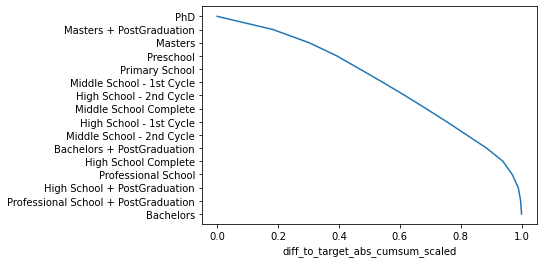


Decision Tree
Score: 0.7814285714285715


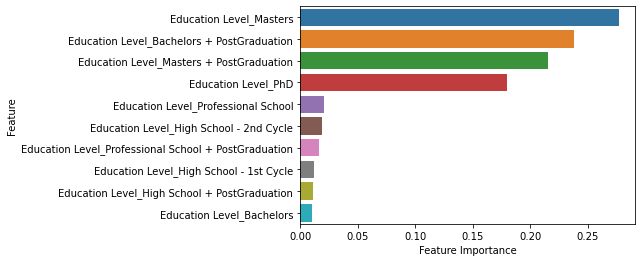

Levels ok


FileNotFoundError: [Errno 2] No such file or directory: 'data/edu_mapping_2.xlsx'

In [16]:
# Education Level 
base_col = 'Education Level'
target_col = 'education'
print(data.columns)

plot_feature_imp(data.loc[~data.Income.isna()], base_col, weighted=False)
levels_equal(data, base_col)

edu_mapping = pd.read_excel(os.path.join(datain_path, 'edu_mapping_2.xlsx'), 'Tabelle2')
mapping_options = ['level_0', 'level_1', 'numeric', 'original', 'low']


#low, medium, high, original
try: 
    if cardinality == 'low':
        m_option = mapping_options[4]
        plot_fct = sns.countplot
    elif cardinality == 'medium': 
        m_option = mapping_options[4]
        plot_fct = sns.countplot
    elif cardinality == 'high': 
        m_option = mapping_options[2]
        plot_fct = sns.histplot
    elif cardinality == 'original':
        m_option = mapping_options[3]
        plot_fct = sns.countplot       
    else: 
        raise NotImplementedError(f'Can not interpret cardinality "{cardinality}" for base feature "{base_col}"!')
except Exception as e:
    error_log['cleaning'].append(e)
    raise Warning(e)
    


#print(data[base_col].value_counts())

#mapping = dict(edu_mapping[['name', mapping_options[2]]].set_index('name'))
#mapping = {k:v for k,v in edu_mapping[['name', mapping_options[2]]].set_index('name').items()}
#mapping = edu_mapping[['name', mapping_options[2]]].set_index('name')
mapping = edu_mapping[['name', m_option]].rename(columns={m_option: target_col})
print(mapping)

# drop if reruning the cell 
if target_col in data.columns: 
    data.drop(columns=[target_col], inplace=True)

data = data.merge(mapping, left_on=base_col, right_on='name', how='left')
data.drop(columns=['name'], inplace=True)  

# plot target col against prediction classes
fig, ax = plt.subplots(figsize=(15,7))
plot_fct(data=data, x=target_col, hue='Income', ax=ax)
#plt.xticks(rotation=45)
plt.show()

cols_to_drop.append(base_col)
cols_to_onehot.append(target_col)


data[[base_col, target_col]]

In [18]:
# years of education 
base_col = 'Years of Education'
target_col = 'education_years'
#data.rename(columns={base_col: target_col}, inplace=True)
data[target_col] = data[base_col]

cols_to_drop.append(base_col)
cols_numeric.append(target_col)
data.head()
#sns.histplot(data=data, y=target_col)

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,...,Money Received,Ticket Price,Income,male,age,native_continent,maritalStatus,household,basearea,education_years
0,12486,Mr. Adam Glover,"July1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,...,0,2273,1.0,1,45.0,Europe,Married,Wife,Northbury,13
1,12487,Mr. Cameron McDonald,"January25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,...,0,0,1.0,1,42.0,Europe,Married,Wife,Northbury,12
2,12488,Mr. Keith Davidson,"May10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,...,0,2321,1.0,1,39.0,Europe,Married,Wife,Northbury,12
3,12489,Mr. Alexander Gill,"March25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,...,5395,0,1.0,1,63.0,Europe,Married,Wife,Northbury,11
4,12490,Mr. Neil Piper,"May29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),...,0,0,1.0,1,33.0,Europe,Single,Family,Northbury,21


Class distributions


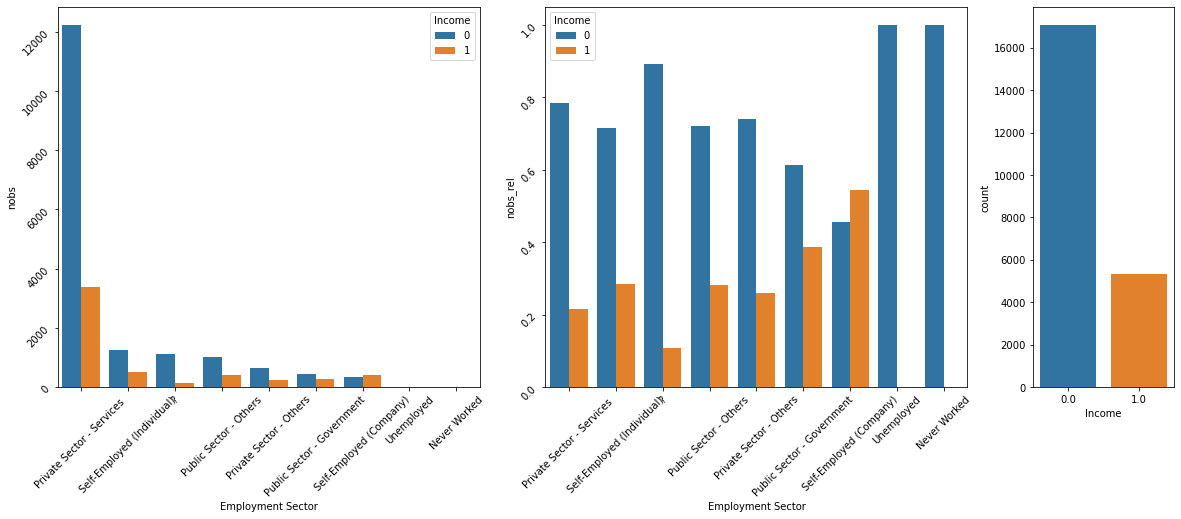


Elbow
TargetClass1_ratio 0.2370982142857143
                           diff_to_target_dir  diff_to_target_abs
Self-Employed (Company)                   pos            0.306807
Unemployed                                neg            0.237098
Never Worked                              neg            0.237098
Public Sector - Government                pos            0.150185
?                                         neg            0.129503
Self-Employed (Individual)                pos            0.046915
Public Sector - Others                    pos            0.043381
Private Sector - Others                   pos            0.021993
Private Sector - Services                 neg            0.021379


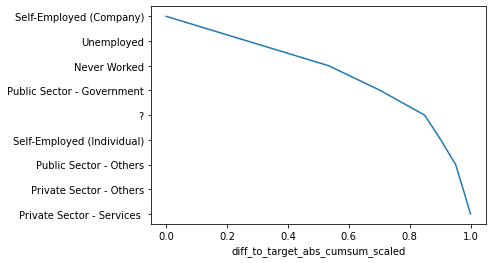


Decision Tree
Score: 0.7658928571428572


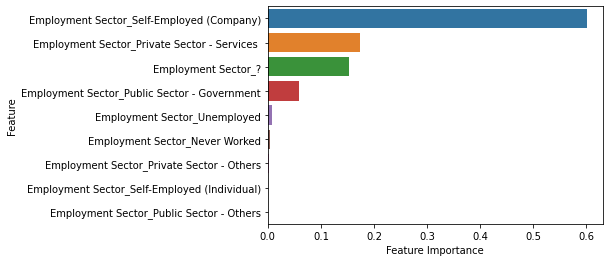

Private Sector - Services     22651
Self-Employed (Individual)     2536
Public Sector - Others         2091
?                              1834
Private Sector - Others        1297
Self-Employed (Company)        1112
Public Sector - Government      958
Unemployed                       14
Never Worked                      7
Name: Employment Sector, dtype: int64
{'Private Sector - Services ': 'private_services', 'Self-Employed (Individual)': 'self_individual', 'Public Sector - Others': 'public_others', '?': 'unknown', 'Private Sector - Others': 'private_others', 'Self-Employed (Company)': 'self_company', 'Public Sector - Government': 'public_gov', 'Unemployed': 'unemployed', 'Never Worked': 'unemployed'}
Levels ok


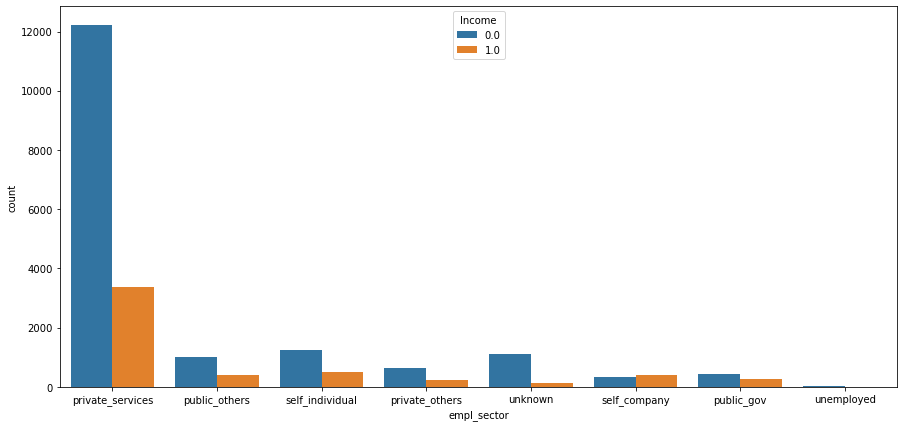

In [19]:
# Employment Sector
base_col = 'Employment Sector'
target_col = 'empl_sector'

plot_feature_imp(data.loc[~data.Income.isna()], base_col, weighted=False)
#levels_equal(data, base_col)

print(data[base_col].value_counts())

#low, medium, high, original
try: 
    if cardinality == 'deprecated':
        mapping = {
            'Private Sector - Services ': 'private',
            'Self-Employed (Individual)': 'self',
            'Public Sector - Others': 'public',
            '?': 'unknown',
            'Private Sector - Others': 'private',
            'Self-Employed (Company)': 'self',
            'Public Sector - Government': 'public',
            'Unemployed': 'delete',
            'Never Worked': 'delete'
            }

    elif cardinality in ['low', 'medium', 'original']: 
        mapping = {
            'Private Sector - Services ': 'private_services',
            'Self-Employed (Individual)': 'self_individual',
            'Public Sector - Others': 'public_others',
            '?': 'unknown',
            'Private Sector - Others': 'private_others',
            'Self-Employed (Company)': 'self_company',
            'Public Sector - Government': 'public_gov',
            'Unemployed': 'unemployed',
            'Never Worked': 'unemployed'
            }
    else: 
        raise NotImplementedError(f'Can not interpret cardinality "{cardinality}" for base feature "{base_col}"!')
except Exception as e:
    error_log['cleaning'].append(e)
    raise Warning(e)


print(mapping)
    
data[target_col] = data[base_col].map(mapping)
levels_equal(data, target_col)


fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(data=data, x=target_col, hue='Income', ax=ax)
plt.show()

cols_to_drop.append(base_col)
cols_to_onehot.append(target_col)

Class distributions
***Features Filtered to top_10 by nobs!***


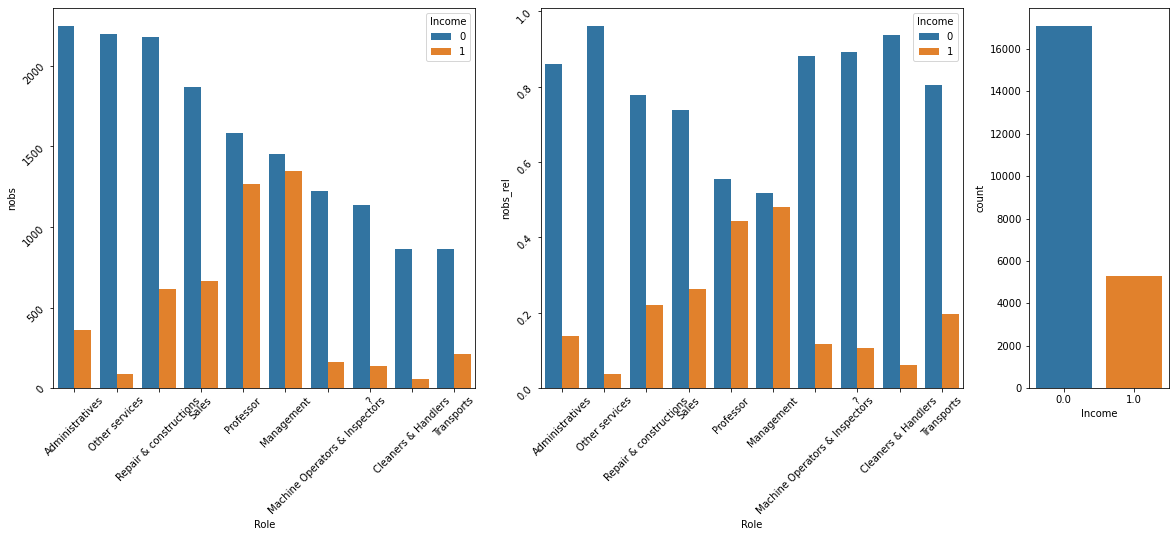


Elbow
TargetClass1_ratio 0.2370982142857143
                               diff_to_target_dir  diff_to_target_abs
Management                                    pos            0.244132
Household Services                            neg            0.237098
Professor                                     pos            0.206917
Other services                                neg            0.198183
Cleaners & Handlers                           neg            0.174191
?                                             neg            0.130096
Agriculture and Fishing                       neg            0.124563
Machine Operators & Inspectors                neg            0.119324
Administratives                               neg            0.098295
IT                                            pos            0.061624
Security                                      pos            0.060680
Transports                                    neg            0.041020
Army                                         

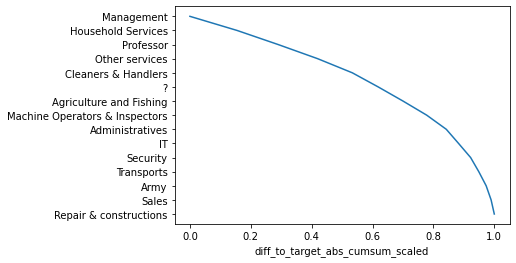


Decision Tree
Score: 0.7629017857142857


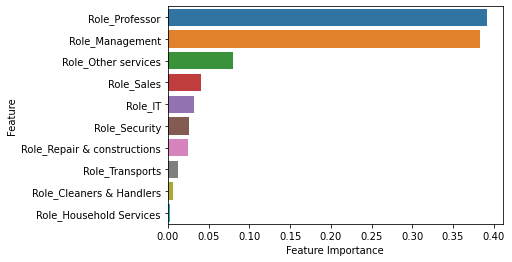

Levels ok
Professor                         4137
Repair & constructions            4087
Management                        4054
Administratives                   3768
Sales                             3641
Other services                    3288
Machine Operators & Inspectors    2000
?                                 1841
Transports                        1594
Cleaners & Handlers               1368
Agriculture and Fishing            992
IT                                 925
Security                           647
Household Services                 149
Army                                 9
Name: Role, dtype: int64
{'Professor': 'Professor', 'Management': 'Management', 'Repair & constructions': 'Constructions', 'Administratives': 'Administratives', 'Sales': 'Sales', 'Other services': 'Services', 'Machine Operators & Inspectors': 'Operator', '?': 'unknown', 'Transports': 'Transports', 'Cleaners & Handlers': 'Cleaners', 'Agriculture and Fishing': 'Agriculture', 'IT': 'IT', 'Security': 'Secu

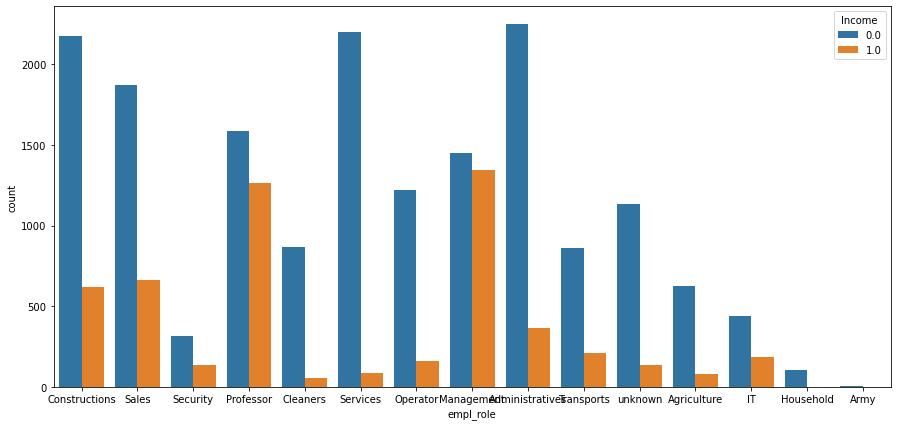

In [20]:
# role
base_col = 'Role'
target_col = 'empl_role'

plot_feature_imp(data.loc[~data.Income.isna()], base_col, weighted=False)
levels_equal(data, base_col)

#low, medium, high, original
try: 
    if cardinality in ['low', 'medium']:
        mapping = {
            'Professor': 'Professor',
            'Management': 'Management',
            'Repair & constructions': 'Operational_low',
            'Administratives': 'Operational',
            'Sales': 'Sales',
            'Other services': 'Services',
            'Machine Operators & Inspectors': 'Operational',
            '?': 'unknown',
            'Transports': 'Operational_low',
            'Cleaners & Handlers': 'Cleaners',
            'Agriculture and Fishing': 'Operational',
            'IT': 'IT_Security',
            'Security': 'IT_Security',
            'Household Services': 'Household',
            'Army': 'Operational_low'
        }
    elif cardinality == 'original':       
        mapping = {
            'Professor': 'Professor',
            'Management': 'Management',
            'Repair & constructions': 'Constructions',
            'Administratives': 'Administratives',
            'Sales': 'Sales',
            'Other services': 'Services',
            'Machine Operators & Inspectors': 'Operator',
            '?': 'unknown',
            'Transports': 'Transports',
            'Cleaners & Handlers': 'Cleaners',
            'Agriculture and Fishing': 'Agriculture',
            'IT': 'IT', 
            'Security': 'Security',
            'Household Services': 'Household',
            'Army': 'Army'
        }
    else: 
        raise NotImplementedError(f'Can not interpret cardinality "{cardinality}" for base feature "{base_col}"!')
except Exception as e:
    error_log['cleaning'].append(e)
    raise Warning(e)

print(data[base_col].value_counts())

print(mapping)
    
data[target_col] = data[base_col].map(mapping)


fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(data=data, x=target_col, hue='Income', ax=ax)
plt.show()

cols_to_drop.append(base_col)
cols_to_onehot.append(target_col)

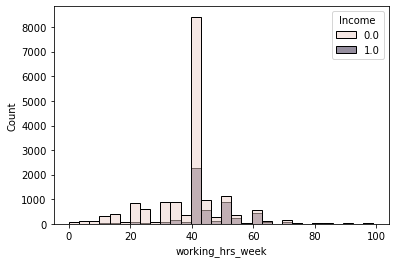

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,...,male,age,native_continent,maritalStatus,household,basearea,education_years,empl_sector,empl_role,working_hrs_week
0,12486,Mr. Adam Glover,"July1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,...,1,45.0,Europe,Married,Wife,Northbury,13,private_services,Constructions,40
1,12487,Mr. Cameron McDonald,"January25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,...,1,42.0,Europe,Married,Wife,Northbury,12,public_others,Constructions,40
2,12488,Mr. Keith Davidson,"May10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,...,1,39.0,Europe,Married,Wife,Northbury,12,private_services,Sales,46
3,12489,Mr. Alexander Gill,"March25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,...,1,63.0,Europe,Married,Wife,Northbury,11,private_services,Security,37
4,12490,Mr. Neil Piper,"May29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),...,1,33.0,Europe,Single,Family,Northbury,21,self_individual,Professor,45


In [21]:
 

# Working Hours per week
base_col = 'Working Hours per week'
target_col = 'working_hrs_week'

data[target_col] = data[base_col]
#data.rename(columns={base_col: target_col}, inplace=True)

#setting working hours per week of those that have never worked or are unemployed to 0
data.loc[data['empl_sector'] == 'unemployed', 'working_hrs_week'] = 0

sns.histplot(data=data, x=target_col, hue='Income', bins=30)
plt.show()

cols_to_drop.append(base_col)
cols_numeric.append(target_col)
data.head()



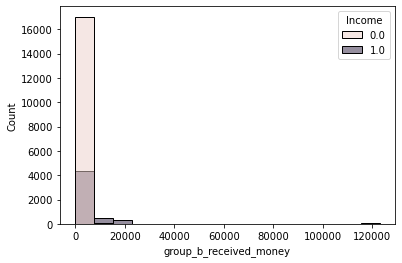

In [22]:
# Money Received
base_col = 'Money Received'
target_col = 'group_b_received_money'


#low, medium, high, original
try: 
    if cardinality == 'low':
        data[target_col] = [1 if v != 0 else 0 for v in data[base_col]]
        plot_fct = sns.countplot
        cols_bool.append(target_col)
    elif cardinality == 'original':
        data[target_col] = data[base_col]
        plot_fct = sns.histplot
        cols_numeric.append(target_col)
    else: 
        raise NotImplementedError(f'Can not interpret cardinality "{cardinality}" for base feature "{base_col}"!')
except Exception as e:
    error_log['cleaning'].append(e)
    raise Warning(e)

cols_to_drop.append(base_col)


plot_fct(data=data, x=target_col, hue='Income')
plt.show()

#data[[base_col, target_col]]



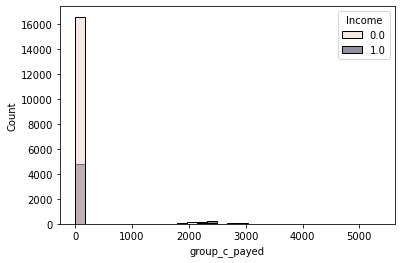

In [23]:
   

# Ticket Price
base_col = 'Ticket Price'
target_col = 'group_c_payed'

#low, medium, high, original
try: 
    if cardinality == 'low':
        data[target_col] = [1 if v != 0 else 0 for v in data[base_col]]
        sns.countplot(data=data, x=target_col, hue='Income')
        cols_bool.append(target_col)
    elif cardinality == 'original':
        data[target_col] = data[base_col]
        sns.histplot(data=data, x=target_col, hue='Income', bins = 30)
        cols_numeric.append(target_col)
    else: 
        raise NotImplementedError(f'Can not interpret cardinality "{cardinality}" for base feature "{base_col}"!')
except Exception as e:
    error_log['cleaning'].append(e)
    raise Warning(e)
    

cols_to_drop.append(base_col)


plt.show()

#data[[base_col, target_col]]

In [24]:
# Check for errors
for name, log in error_log.items():
    if len(log) > 0: 
        print(f'{name}:\n {log}')
        raise Warning('Errors occured! See above.')

In [25]:
error_log

{'cleaning': []}

In [26]:
# drop cols
#cols_to_drop.append('CITIZEN_ID')
col_with_index = ['CITIZEN_ID']
data.drop(columns=cols_to_drop, inplace=True)


In [27]:
combined_data = data.copy().set_index(col_with_index)


In [28]:
## profile report

create_cleaning_report = False
if create_cleaning_report: 
    profile = ProfileReport(
        data,
        title=f'Cleaned data {dataset_name}' ,
        minimal=False, 
        correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
        }
    )
    profile.to_file(os.path.join(explorations_path, f'profile_data_cleaned_{dataset_name}.html'))


In [29]:
combined_data.shape

(32500, 14)

In [30]:
test_data = combined_data.copy().loc[combined_data.Income.isna()]
test_data.drop(columns='Income', inplace=True)
test_data.info()

data = combined_data.copy().loc[~combined_data.Income.isna()]
data.Income = data.Income.astype(int)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10100 entries, 34886 to 44985
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Education Level         10100 non-null  object 
 1   male                    10100 non-null  int64  
 2   age                     10100 non-null  float64
 3   native_continent        10100 non-null  object 
 4   maritalStatus           10100 non-null  object 
 5   household               10100 non-null  object 
 6   basearea                10100 non-null  object 
 7   education_years         10100 non-null  int64  
 8   empl_sector             10100 non-null  object 
 9   empl_role               10100 non-null  object 
 10  working_hrs_week        10100 non-null  int64  
 11  group_b_received_money  10100 non-null  int64  
 12  group_c_payed           10100 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 1.1+ MB
<class 'pandas.core.frame.Data

# Explorations

In [31]:
plot_explorations = True

In [32]:
data.isna().sum()

Education Level           0
Income                    0
male                      0
age                       0
native_continent          0
maritalStatus             0
household                 0
basearea                  0
education_years           0
empl_sector               0
empl_role                 0
working_hrs_week          0
group_b_received_money    0
group_c_payed             0
dtype: int64

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22400 entries, 12486 to 34885
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Education Level         22400 non-null  object 
 1   Income                  22400 non-null  int32  
 2   male                    22400 non-null  int64  
 3   age                     22400 non-null  float64
 4   native_continent        22400 non-null  object 
 5   maritalStatus           22400 non-null  object 
 6   household               22400 non-null  object 
 7   basearea                22400 non-null  object 
 8   education_years         22400 non-null  int64  
 9   empl_sector             22400 non-null  object 
 10  empl_role               22400 non-null  object 
 11  working_hrs_week        22400 non-null  int64  
 12  group_b_received_money  22400 non-null  int64  
 13  group_c_payed           22400 non-null  int64  
dtypes: float64(1), int32(1), int64(5),

In [34]:
print(data.shape[1])
data.shape[1] - (len(cols_numeric) + len(cols_bool) + len(cols_to_onehot))

14


2

In [35]:
# check colmuns
expected_ncols = len(cols_numeric) + len(cols_bool)
for cat_col in cols_to_onehot: 
    expected_ncols += data[cat_col].nunique()
    
expected_ncols

87

In [36]:
print(len(cols_to_drop))
cols_to_drop

12


['Name',
 'Birthday',
 'Native Continent',
 'Marital Status',
 'Lives with',
 'Base Area',
 'Years of Education',
 'Employment Sector',
 'Role',
 'Working Hours per week',
 'Money Received',
 'Ticket Price']

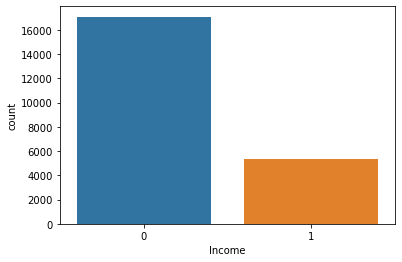

In [37]:
# target distribution

sns.countplot(data=data, x='Income')
plt.show()

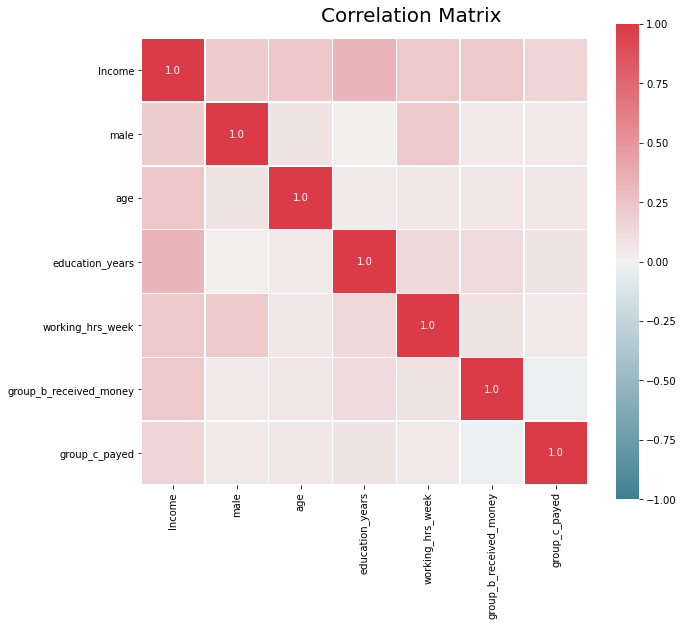

In [38]:
if plot_explorations: 
    # Prepare figure
    fig = plt.figure(figsize=(10, 8))

    # Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
    corr = np.round(data.corr(method="pearson"), decimals=2)

    # Build annotation matrix (values above |0.5| will appear annotated in the plot)
    mask_annot = np.absolute(corr.values) >= 0.5
    annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

    # Layout
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Correlation Matrix", fontsize=20)

    plt.savefig(os.path.join(explorations_path, 'correlation_matrix.png'), dpi=200)
    plt.show()

age
education_years
working_hrs_week
group_b_received_money
group_c_payed
male


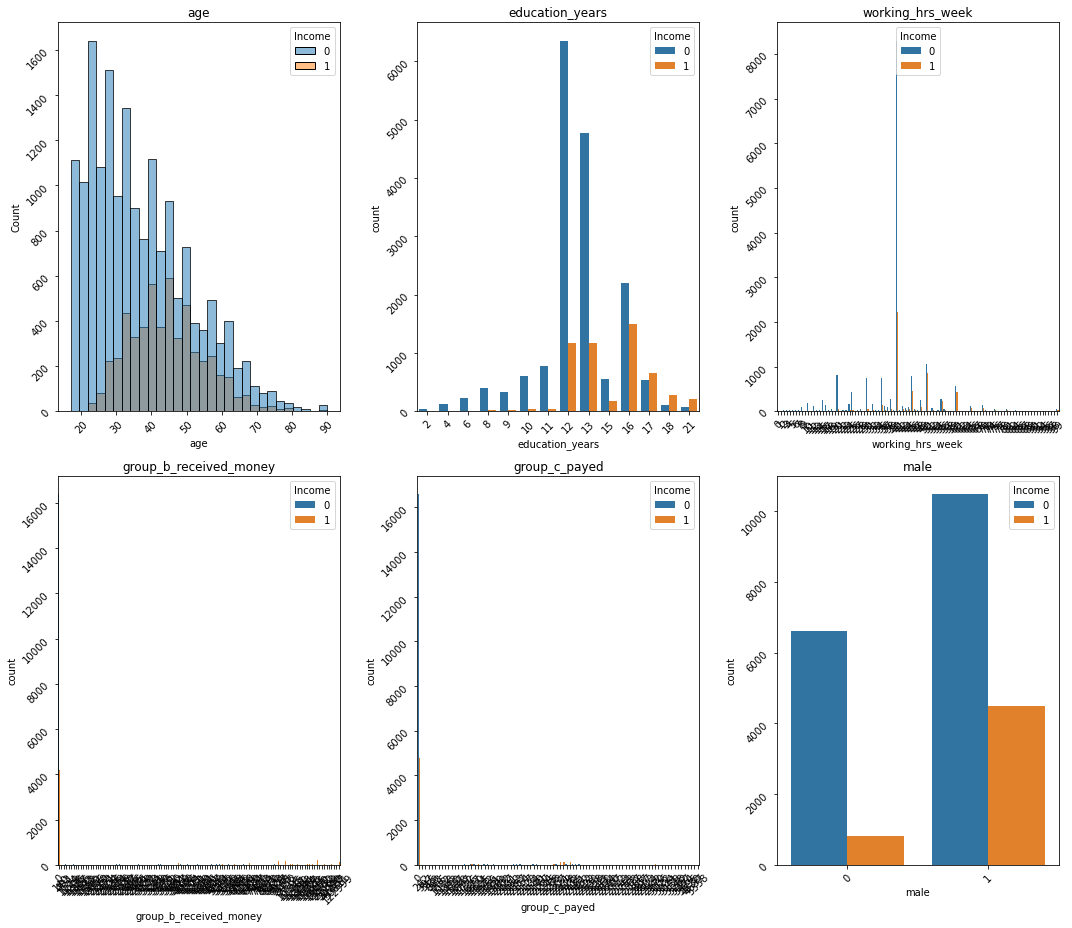

In [39]:
# distributions 
if plot_explorations: 
    plotdata = data.loc[:,cols_numeric + cols_bool]
    ncols = 3
    n_plots = plotdata.shape[1]
    nrows = int(np.ceil(n_plots/ncols))



    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,13))
    col_no = 0
    for i in range(nrows):
        for j in range(ncols): 
            if col_no < n_plots:
                col = plotdata.columns[col_no]
                print(col)
                if data[col].dtype in [np.float, np.int]: 
                    sns.histplot(data=plotdata, hue=data.Income, x=col, ax=ax[i,j], bins=30).set_title(col)
                else : 
                    sns.countplot(data=plotdata, hue=data.Income, x=col, ax=ax[i,j], dodge=True).set_title(col)
                ax[i,j].tick_params(labelrotation=45)
                col_no +=1

    fig.tight_layout()

    plt.savefig(os.path.join(explorations_path, 'distributions.png'), dpi=200)
    plt.show()


# Data Preparation

In [40]:
# prep config

prep_config = {
    'overSampling': False, 
    'scale': 'standard', # False,
    'feature_selection':False#'boruta'
}

In [41]:
# split the cleaned data into test and train data 
X_train = data.copy().drop(['Income'], axis=1)#.values
y = data.copy().loc[:,'Income'].values

X_test = test_data.copy()#.values
X_test.shape

print('X_train.shape', X_train.shape)
print('y.shape', y.shape)
print('X_test.shape', X_test.shape)

X_train.shape (22400, 13)
y.shape (22400,)
X_test.shape (10100, 13)


In [42]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22400 entries, 12486 to 34885
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Education Level         22400 non-null  object 
 1   male                    22400 non-null  int64  
 2   age                     22400 non-null  float64
 3   native_continent        22400 non-null  object 
 4   maritalStatus           22400 non-null  object 
 5   household               22400 non-null  object 
 6   basearea                22400 non-null  object 
 7   education_years         22400 non-null  int64  
 8   empl_sector             22400 non-null  object 
 9   empl_role               22400 non-null  object 
 10  working_hrs_week        22400 non-null  int64  
 11  group_b_received_money  22400 non-null  int64  
 12  group_c_payed           22400 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 2.4+ MB
<class 'pandas.core.frame.Data

## One hot encode and scale

In [43]:
# https://towardsdatascience.com/feature-selection-with-borutapy-f0ea84c9366

def onehot_scale(X_train, X_test, verbose=False): 
    ###Creating series for categorical test and train
    X_train_bool = X_train[cols_bool]
    X_test_bool = X_test[cols_bool]

    ###Instantiating One Hot Encoder
    ohe = OneHotEncoder()
    ###Creating series for categorical test and train
    X_train_cat = X_train[cols_to_onehot]
    X_test_cat = X_test[cols_to_onehot]
    ###Fitting encoder to training categorical features and transforming ###test and train
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe = ohe.transform(X_test_cat)

    ###Converting series to dataframes
    columns = ohe.get_feature_names(input_features=X_train_cat.columns)
    X_train_processed = pd.DataFrame(X_train_ohe.todense(), columns=columns, index=X_train_bool.index)
    X_test_processed = pd.DataFrame(X_test_ohe.todense(), columns=columns, index=X_test_bool.index)



    ###Instantiating Standard Scaler
    ss = StandardScaler()
    ###Converting continuous feature values to floats
    X_train_cont = X_train[cols_numeric].astype(float)
    X_test_cont = X_test[cols_numeric].astype(float)
    ###Fitting scaler to training continuous features and transforming ###train and test
    X_train_scaled = ss.fit_transform(X_train_cont)
    X_test_scaled = ss.transform(X_test_cont)


    ###Concatenating scaled and encoded dataframes
    X = pd.concat([pd.DataFrame(X_train_scaled, index=X_train_bool.index), X_train_bool, X_train_processed], axis=1).values
    X_test_ = pd.concat([pd.DataFrame(X_test_scaled, index=X_test_bool.index),X_test_bool, X_test_processed], axis=1).values
    
    if verbose: 
        print('X_train_scaled.shape', X_train_scaled.shape)
        print('X_train_bool.shape', X_train_bool.shape)
        print('X_train_processed.shape', X_train_processed.shape)

        print('X.shape', X.shape)
        print('y.shape', y.shape)
        print('X_test.shape', X_test_.shape)
    
    return X, X_test_

if True: 
    X, X_test_ = onehot_scale(X_train, X_test)


In [93]:
def onehot_scale(X_train, X_test, verbose=False): 
    ###Creating series for categorical test and train
    X_train_bool = X_train[cols_bool]
    X_test_bool = X_test[cols_bool]

    ###Instantiating One Hot Encoder
    ohe = OneHotEncoder()
    ###Creating series for categorical test and train
    X_train_cat = X_train[cols_to_onehot]
    X_test_cat = X_test[cols_to_onehot]
    ###Fitting encoder to training categorical features and transforming ###test and train
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe = ohe.transform(X_test_cat)

    ###Converting series to dataframes
    columns = ohe.get_feature_names(input_features=X_train_cat.columns)
    X_train_processed = pd.DataFrame(X_train_ohe.todense(), columns=columns, index=X_train_bool.index)
    X_test_processed = pd.DataFrame(X_test_ohe.todense(), columns=columns, index=X_test_bool.index)



    ###Instantiating MinMax Scaler
    mm = MinMaxScaler()
    ###Converting continuous feature values to floats
    X_train_cont = X_train[cols_numeric].astype(float)
    X_test_cont = X_test[cols_numeric].astype(float)
    ###Fitting scaler to training continuous features and transforming ###train and test
    X_train_scaled = mm.fit_transform(X_train_cont)
    X_test_scaled = mm.transform(X_test_cont)


    ###Concatenating scaled and encoded dataframes
    X = pd.concat([pd.DataFrame(X_train_scaled, index=X_train_bool.index), X_train_bool, X_train_processed], axis=1).values
    X_test_ = pd.concat([pd.DataFrame(X_test_scaled, index=X_test_bool.index),X_test_bool, X_test_processed], axis=1).values
    
    if verbose: 
        print('X_train_scaled.shape', X_train_scaled.shape)
        print('X_train_bool.shape', X_train_bool.shape)
        print('X_train_processed.shape', X_train_processed.shape)

        print('X.shape', X.shape)
        print('y.shape', y.shape)
        print('X_test.shape', X_test_.shape)
    
    return X, X_test_

if True: 
    X, X_test_ = onehot_scale(X_train, X_test)

## feature_selection

In [44]:
# https://github.com/scikit-learn-contrib/boruta_py
# https://towardsdatascience.com/feature-selection-with-borutapy-f0ea84c9366


# load X and y
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
# X = pd.read_csv('examples/test_X.csv', index_col=0).values
# y = pd.read_csv('examples/test_y.csv', header=None, index_col=0).values
# y = y.ravel()

if prep_config['feature_selection'] == 'boruta': 


    # define random forest classifier, with utilising all cores and
    # sampling in proportion to y labels
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

    # define Boruta feature selection method
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)

    # find all relevant features - 5 features should be selected
    feat_selector.fit(X, y)

    # check selected features - first 5 features are selected
    print(feat_selector.support_)
    # check ranking of features
    print(feat_selector.ranking_)

    # call transform() on X to filter it down to selected features
    X_filtered = feat_selector.transform(X)
    X_test_filtered = feat_selector.transform(X_test_)

    
    X_metadata = pd.DataFrame({
    'Features': (X_train.drop('Income', axis=1).columns.to_list()),
    'support': (feat_selector.support_), 
    'ranking': (feat_selector.ranking_)
    })

    X_metadata
    
    X_metadata.support.sum()

## overSampling to cope with class imbalance 

C:\Users\doris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


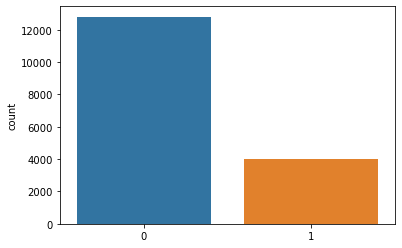

In [45]:
## Train test split on updated X
X_t, X_val, y_t, y_val = train_test_split(X, y, random_state=42, stratify=None)
sns.countplot(y_t)
plt.show()

# https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTE.html
if prep_config['overSampling']: 
    sm = SMOTE(random_state=2, n_jobs=-1, k_neighbors=5, sampling_strategy='auto')
    X_t, y_t = sm.fit_sample(X_t, y_t)
    sns.countplot(y_t)
    plt.show()

# Modelling

In [82]:
# define wich models to run
modelling_config = {
    'naive_bayes': False,
    'logistic_regression': False,
    'knn': False,
    'bagging_knn': False,
    'svc': False,
    'dt': False,
    'random_forest': False, 
    'boosted_tree': True, 
    'boosted_tree_gs': False,
    'boosted_tree_after_gs': False,
    'mlp': False,
    'mlp_gs': False,
    'mlp_after_gs': False, 
    'ensemble1': False,
    'ensemble2': False,
    'adaboost': False,
    'stacking1': False,
    'stacking2' : False,
    'stacking3' : False
}


In [47]:
def save_submission_csv(model, X_test_, test_data, file_no): 
    test_pred = model.predict(X_test_)
    submission_df = pd.DataFrame({'Income':test_pred}, index=test_data.index).reset_index()
    submission_df.to_csv(f'Group26_Version{file_no}.csv', index=False)

def train_model(model, params, X_t, y_t, X_val, y_val):
    clf = model(random_state=0, verbose=False, **params)

    clf.fit(X_t, y_t)
    predicted = clf.predict(X_val)

    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    print('Acc:', clf.score(X_val, y_val))
    return clf


In [48]:
def train_model_simple(model, params, X_t, y_t, X_val, y_val):
    clf = model(**params)

    clf.fit(X_t, y_t)
    predicted = clf.predict(X_val)

    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    print('Acc:', clf.score(X_val, y_val))
    return clf


## <font color='#E8800A'>Naive Bayes</font> <a class="anchor" id="first-bullet"></a>
  [Back to TOC](#toc)

In [49]:
if modelling_config['naive_bayes']: 
    ###Instantiating gaussian naive bayes
    modelNB = GaussianNB()
    ###Fitting naive bayes to train
    modelNB.fit(X_t,y_t)
    ###Predicting on test data
    predicted = modelNB.predict(X_val)
    ###Training Score
    modelNB.score(X_t, y_t)
    ###Test Score
    modelNB.score(X_val,y_val)
    
    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    # f1_micro: 0.48178571428571426

In [50]:
###used data scaled with minmax here 

if modelling_config['naive_bayes']: 
    ###Instantiating multinomial naive bayes
    modelMNB = MultinomialNB()
    ###Fitting naive bayes to train
    modelMNB.fit(X_t,y_t)
    ###Predicting on test data
    predicted = modelMNB.predict(X_val)
    ###Training Score
    modelMNB.score(X_t, y_t)
    ###Test Score
    modelMNB.score(X_val,y_val)
    
    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    # f1_micro: 0.7825
    
if modelling_config['naive_bayes']: 
    ###Instantiating complement naive bayes
    modelCNB = ComplementNB()
    ###Fitting naive bayes to train
    modelCNB.fit(X_t,y_t)
    ###Predicting on test data
    predicted = modelCNB.predict(X_val)
    ###Training Score
    modelCNB.score(X_t, y_t)
    ###Test Score
    modelCNB.score(X_val,y_val)
    
    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    # f1_micro: 0.7405357142857143

## <font color='#E8800A'>Logistic Regression</font> <a class="anchor" id="second-bullet"></a>
  [Back to TOC](#toc)

In [51]:
if modelling_config['logistic_regression']: 
    ###Instantiating logistic regression
    log_model = LogisticRegression()
    ###Fitting logistic regression to train
    log_model.fit(X_t,y_t)
    ###Predicting on test data
    predicted = log_model.predict(X_val)
    ###Training Score
    log_model.score(X_t,y_t)
    ###Test Score
    log_model.score(X_val,y_val)
    
    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    # f1_micro: 0.8528571428571429

In [103]:
if modelling_config['logistic_regression']: 
    model = LogisticRegression(random_state=0, verbose=False)
    f1w = make_scorer(f1_score, average='micro')


    parameter_space = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': list(range(1,10)),
        'class_weight':[{0:1.0, 1:1.0},{0:1.0, 1:50.0}],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'multi_class':['auto','ovr','multinomial']
        #dual
        #tolerance for stopping criteria
        #max_iter
        #refit
        #intercept_scaling
        #l1_ratios
    }

    lr_gs = GridSearchCV(model, parameter_space, n_jobs=-1, scoring=f1w, cv=5, verbose=10)

    lr_gs.fit(X_t, y_t)

    print(f'{lr_gs.scoring}: {lr_gs.best_score_}')
    # make_scorer(f1_score, average=micro): 0.85


In [104]:
# lr_gs.best_params_
#{'C': 1,
# 'class_weight': {0: 1.0, 1: 1.0},
# 'multi_class': 'auto',
# 'penalty': 'l2',
# 'solver': 'liblinear'}
lr = LogisticRegression(C=1,class_weight={0: 1.0, 1: 1.0},penalty = 'l2',solver='liblinear',multi_class='auto')

if modelling_config['logistic_regression']: 
    lr_params_short = {
        'C': 1,
        'class_weight': {0: 1.0, 1: 1.0},
        'penalty': 'l2',
        'solver': 'liblinear',
        'multi_class': 'auto'
    }

    # train final model with best_params from grid search 
    lr = train_model(
        LogisticRegression,
        lr_params_short,
    #   lr_gs.best_params_,
        X_t, y_t, X_val, y_val
    )
    # f1_micro: 0.8530357142857142

    scores = cross_val_score(
        lr, X_val, y_val, cv=10, scoring='f1_micro'
    )
    print(f'{scores.mean()} ~ {scores.std()}')
    # 0.8510714285714286 ~ 0.008151937293223808

In [105]:
###Randomized Search

if modelling_config['logistic_regression']: 
    rsearch = RandomizedSearchCV(estimator=LogisticRegression(random_state=0, verbose=False), param_distributions=parameter_space, n_iter=100)
    rsearch.fit(X_t, y_t)
    # rsearch.best_score_): 0.8498809523809523
    lr_params_short = {
        'C': 6,
        'class_weight': {0: 1.0, 1: 1.0},
        'penalty': 'l2',
        'solver': 'saga',
        'multi_class': 'ovr'
    }

    # train final model with best_params from grid search 
    lr = train_model(
        LogisticRegression,
        lr_params_short,
    #   rsearch.best_params_ : {'solver': 'saga','penalty': 'l2','multi_class': 'ovr','class_weight': {0: 1.0, 1: 1.0},'C': 6}
        X_t, y_t, X_val, y_val
    )
    # f1_micro: 0.8528571428571429

    scores = cross_val_score(
        lr, X_val, y_val, cv=10, scoring='f1_micro'
    )
    print(f'{scores.mean()} ~ {scores.std()}')
    # 0.8514285714285714 ~ 0.008329931278350444

## <font color='#E8800A'>KNN</font> <a class="anchor" id="third-bullet"></a>
  [Back to TOC](#toc)

In [54]:
if modelling_config['knn']: 
    ###Instantiating k nearest neighbors 
    KNNmodel = KNeighborsClassifier()
    ###Fitting k nearnest neighbors to train
    KNNmodel.fit(X_t,y_t)
    ###Predicting on test data
    predicted = KNNmodel.predict(X_val)
    ###Training Score
    KNNmodel.score(X_t,y_t)
    ###Test Score
    KNNmodel.score(X_val,y_val)
    
    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    # f1_micro: 0.8351785714285714

In [55]:
if modelling_config['knn']: 
    model = KNeighborsClassifier()
    f1w = make_scorer(f1_score, average='micro')


    parameter_space = {
        'n_neighbors': list(range(1,15)),
        'weights': ['uniform','distance'],
        'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size' : [5,10,15,30,45] 
    }

    knn_gs = GridSearchCV(model, parameter_space, n_jobs=-1, scoring=f1w, cv=5, verbose=10)

    knn_gs.fit(X_t, y_t)

    print(f'{knn_gs.scoring}: {knn_gs.best_score_}')
    # make_scorer(f1_score, average=micro): 0.8419047619047619


In [56]:
# knn_gs.best_params_
#{'algorithm': 'brute',
# 'leaf_size': 15,
# 'n_neighbors': 11,
# 'weights': 'uniform'}
knn = KNeighborsClassifier(algorithm = 'brute', n_neighbors = 11, weights = 'uniform')

if modelling_config['knn']: 
    knn_params_short = {
        'algorithm': 'brute',
        'n_neighbors': 11,
        'weights': 'uniform'
    }

    # train final model with best_params from grid search 
    knn = train_model_simple(
        KNeighborsClassifier,
        knn_params_short,
    #   knn_gs.best_params_,
        X_t, y_t, X_val, y_val
    )
    # f1_micro: 0.8483928571428572

    scores = cross_val_score(
        knn, X_val, y_val, cv=10, scoring='f1_micro'
    )
    print(f'{scores.mean()} ~ {scores.std()}')
    # 0.8396428571428572 ~ 0.008096988606253283

In [57]:
# bagging knn
if modelling_config['bagging_knn']: 
    ###Instantiating k nearest neighbors 
    bagging_knn = BaggingClassifier(base_estimator = knn, random_state = 0)
    ###Fitting k nearnest neighbors to train
    bagging_knn.fit(X_t,y_t)
    ###Predicting on test data
    predicted = bagging_knn.predict(X_val)
    ###Training Score
    bagging_knn.score(X_t,y_t)
    ###Test Score
    bagging_knn.score(X_val,y_val)
    
    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    # f1_micro: 0.8469642857142857

## <font color='#E8800A'>Support Vector Machines</font> <a class="anchor" id="fourth-bullet"></a>
  [Back to TOC](#toc)

In [58]:
if modelling_config['svc']: 
    ###Instantiating support vector classifier
    svc_model = SVC(gamma='scale')
    ###Fitting logistic regression to train
    svc_model.fit(X_t,y_t)
    ###Predicting on test data
    predicted = svc_model.predict(X_val)
    ###Training Score
    svc_model.score(X_t,y_t)
    ###Test Score
    svc_model.score(X_val,y_val)
    
    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    # f1_micro: 0.8625

In [59]:
if modelling_config['svc']: 
    model = SVC()
    f1w = make_scorer(f1_score, average='micro')


    parameter_space = {
        'C': [0.1,0.5,1,10,100],
        'kernel': ['linear','poly','rbf','sigmoid'],
        'gamma': ['scale', 'auto']
    }

    svc_gs = GridSearchCV(model, parameter_space, n_jobs=-1, scoring=f1w, cv=5, verbose=10)

    svc_gs.fit(X_t, y_t)

    print(f'{svc_gs.scoring}: {svc_gs.best_score_}')
    # make_scorer(f1_score, average=micro): 0.85375


In [60]:
# svc_gs.best_params_
#{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
svc = SVC(C = 1, gamma = 'scale', kernel = 'rbf', random_state=0, verbose=False, probability = True)


if modelling_config['svc']: 
    svc_params_short = {
        'C': 1,
        'gamma': 'scale',
        'kernel': 'rbf'
    }

    # train final model with best_params from grid search 
    svc = train_model(
        SVC,
        svc_params_short,
    #   svc_gs.best_params_,
        X_t, y_t, X_val, y_val
    )
    # f1_micro:0.8625

    scores = cross_val_score(
        svc, X_val, y_val, cv=10, scoring='f1_micro'
    )
    print(f'{scores.mean()} ~ {scores.std()}')
    # 0.8551785714285713 ~ 0.012511474325430974

## Decision Trees

In [64]:
if modelling_config['dt']: 
    ###Instantiating Decision Tree Classifier
    dt = DecisionTreeClassifier()
    ###Fitting Decision Tree Classifier to train and test
    dt.fit(X_t, y_t)
    ###Predicting on test data
    predicted = dt.predict(X_val)
    ###Test Score
    dt.score(X_val, y_val)
    ###Training Score
    dt.score(X_t, y_t)

    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    # f1_micro: 0.8139285714285716


## Random Forest

In [65]:
rf2 = RandomForestClassifier(n_jobs=-1, n_estimators=500, oob_score=True, max_depth=6, random_state=42)

if modelling_config['random_forest']: 
    ###Instantiating Random Forest Classifier
    rf2 = RandomForestClassifier(n_jobs=-1, n_estimators=500, oob_score=True, max_depth=6, random_state=42)
    ###Fitting Random Forest Classifier to train and test
    rf2.fit(X_t, y_t)
    ###Predicting on test data
    predicted = rf2.predict(X_val)
    ###Test Score
    rf2.score(X_val, y_val)
    ###Training Score
    rf2.score(X_t, y_t)

    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    # f1_micro: 0.8482142857142857


## Boosted Trees

In [69]:
clf1 = GradientBoostingClassifier(
    learning_rate=.1,
    random_state=0, verbose=False,
    subsample=1,
    n_estimators=1000, max_depth=7, min_impurity_decrease = 0.1,
    max_features='auto',
    n_iter_no_change=30, validation_fraction=0.1,
    warm_start=False
)

In [80]:
clf1 = GradientBoostingClassifier(
    learning_rate=.1,
    random_state=0, verbose=False,
    subsample=1,
    n_estimators=1000, max_depth=7, min_impurity_decrease = 0.1,
    max_features='auto',
    n_iter_no_change=30, validation_fraction=0.1,
    warm_start=False
)

if modelling_config['boosted_tree']: 
    clf1.fit(X_t, y_t)
    predicted = clf1.predict(X_val)

    print(classification_report(y_val, predicted))
    print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
    # f1_micro: 0.8755357142857143
    print('Acc:', clf1.score(X_val, y_val))

    save_submission_csv(clf1, X_test_, test_data, '12')
    
    scores = cross_val_score(
    clf1, X, y, cv=10, scoring='f1_micro'
    )
    print(f'{scores.mean()} ~ {scores.std()}')
    # 0.8708482142857144 ~ 0.006533890504710872

### grid search 

In [ ]:
if modelling_config['boosted_tree_gs']: 
    model = GradientBoostingClassifier(random_state=0, verbose=False)
    f1w = make_scorer(f1_score, average='micro')


    parameter_space = {
        'learning_rate':[.1, .05],
        'subsample':[1, .9],
        'n_estimators':[1000], 
        'min_samples_split': [2,3],
        'max_depth': list(range(5,9)), 
        'min_impurity_decrease': [0.0, 0.1],
        'max_features': ['auto', None],
        'n_iter_no_change': [30],
        'validation_fraction': [0.1],
        'warm_start': [False], 
        'ccp_alpha': [0.0]
    }


    clf_gs = GridSearchCV(model, parameter_space, n_jobs=-1, scoring=f1w, cv=5, verbose=10)

    clf_gs.fit(X, y)

    print(f'{clf_gs.scoring}: {clf_gs.best_score_}')
    # make_scorer(f1_score, average=micro): 0.8710267857142856


In [ ]:
# clf3.get_params()

if modelling_config['boosted_tree_after_gs']: 
    clf3_params_short = {
        'ccp_alpha': 0.0,
        'learning_rate': 0.1,
        'max_depth': 6,
        'max_features': 'auto',
        'min_impurity_decrease': 0.1,
        'min_samples_split': 3,
        'n_estimators': 1000,
        'n_iter_no_change': 30,
        'subsample': 1,
        'validation_fraction': 0.1,
        'warm_start': False
    }

    # train final model with best_params from grid search 
    clf3 = train_model(
        GradientBoostingClassifier,
        clf3_params_short,
    #   clf_gs.best_params_,
        X_t, y_t, X_val, y_val
    )
    # f1_micro: 0.8753571428571428

    scores = cross_val_score(
        clf3, X, y, cv=10, scoring='f1_micro'
    )
    print(f'{scores.mean()} ~ {scores.std()}')
    # 0.8708482142857144 ~ 0.007379047013092432

    # save
    save_submission_csv(clf3, X_test_, test_data, '11')


## MLP

In [70]:
if modelling_config['mlp']: 
        model = MLPClassifier(
            alpha=0.000001,
            activation='relu', # [tanh, relu]
            random_state=0, verbose=False, 
            hidden_layer_sizes = (100, ),# [(100,), (50,50), (200,)]
            max_iter=1000, early_stopping=True, 
            learning_rate_init = 0.001,  # [0.05, 0.001, 0.005]
            learning_rate='constant', # ['invscaling', 'constant']
            momentum=0.9, #[0.8, 0.9]
            solver='adam', # ['adma', 'sgd']
            beta_1 = .9, #[.7, .8, .9]
            beta_2 = .999 #[.9, .99, .8]
        )
        model.fit(X_t, y_t)
        predicted = model.predict(X_val)

        print(classification_report(y_val, predicted))
        print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
        # f1_micro: 0.8614285714285714
        print('Acc:', model.score(X_val, y_val))
        
        if True: 
                scores = cross_val_score(
                model, X, y, cv=5, scoring='f1_micro'
                )
                print(f'{scores.mean()} ~ {scores.std()}')
                # 0.8549107142857144 ~ 0.004171181652427915
            

In [71]:
if modelling_config['mlp_gs']: 
    model = MLPClassifier(random_state=0, verbose=False, max_iter=1000, early_stopping=True)
    f1w = make_scorer(f1_score, average='micro')
   
    params = {
        'alpha': (10.0 ** -np.arange(1, 7)).tolist(), 
        'activation': ['tanh', 'relu'],  
        'hidden_layer_sizes': [(100,), (50,50), (200,), (50,50, 50 )], 
        'learning_rate_init': [0.05, 0.001, 0.005],
        'learning_rate':['adaptive', 'constant'], 
        'momentum':[0.8, 0.9], 
        'solver': ['adam'], #['adma', 'sgd']
        'beta_1': [.7, .8, .9], 
        'beta_2':[.9, .99, .8]
    }


    mlp_gs = GridSearchCV(model, params, n_jobs=-1, scoring=f1w, cv=5, verbose=10)

    mlp_gs.fit(X, y)

    print(f'{mlp_gs.scoring}: {mlp_gs.best_score_}')
    #make_scorer(f1_score, average=micro): 0.8584375


In [72]:
mlp_gs_best_params = {
    'activation': 'tanh',
    'alpha': 0.0001,
    'beta_1': 0.9,
    'beta_2': 0.8,
    'hidden_layer_sizes': (50, 50, 50),
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.001,
    'momentum': 0.8,
    'solver': 'adam'
}

mlp_after_gs = MLPClassifier(random_state=0, verbose=False, max_iter=1000, early_stopping=True, **mlp_gs_best_params)


if modelling_config['mlp_after_gs']: 
        mlp_after_gs.fit(X_t, y_t)
        predicted = mlp_after_gs.predict(X_val)

        print(classification_report(y_val, predicted))
        print('f1_micro:', f1_score(y_val, predicted, average='micro')) 
        # f1_micro: 0.8546428571428571
        print('Acc:', mlp_after_gs.score(X_val, y_val))
        

## Ensembles - VotingClassifier

In [83]:

if modelling_config['ensemble1']: 
    eclf = VotingClassifier(
        estimators=[('rf', rf2), ('gbt', clf1), ('mlp', mlp_after_gs)],
        voting='soft')

    eclf.fit(X_t, y_t)
    predicted = eclf.predict(X_val)

    print(classification_report(y_val, predicted))

    eclf.score(X_val, y_val)
    
    if True:
        scores = cross_val_score(
            eclf, X, y, cv=5, scoring='f1_micro'
        )
        print(f'{scores.mean()} ~ {scores.std()}')
        #0.8653125000000002 ~ 0.0036202026665559423

In [84]:

if modelling_config['ensemble2']: 
    eclf = VotingClassifier(
        estimators=[('gbt', clf1), ('svc', svc)],
        voting='soft')

    eclf.fit(X_t, y_t)
    predicted = eclf.predict(X_val)

    print(classification_report(y_val, predicted))

    eclf.score(X_val, y_val)
    
    if True:
        scores = cross_val_score(
            eclf, X, y, cv=5, scoring='f1_micro'
        )
        print(f'{scores.mean()} ~ {scores.std()}')
        #0.8668750000000001 ~ 0.004359484148476345

## Adaboost

In [88]:

if modelling_config['adaboost']: 
    ab = AdaBoostClassifier(random_state = 5)

    ab.fit(X_t, y_t)
    predicted = ab.predict(X_val)

    print(classification_report(y_val, predicted))

    ab.score(X_val, y_val)
    
    if True:
        scores = cross_val_score(
            ab, X, y, cv=5, scoring='f1_micro'
        )
        print(f'{scores.mean()} ~ {scores.std()}')
        # 0.8580357142857145 ~ 0.004430677062785573

## Stacking

In [87]:

if modelling_config['stacking1']: 
    sclf = StackingClassifier(
        estimators=[('gbt', clf1), ('mlp', mlp_after_gs)],
        final_estimator=svc)

    sclf.fit(X_t, y_t)
    predicted = sclf.predict(X_val)

    print(classification_report(y_val, predicted))

    sclf.score(X_val, y_val)
    
    if True:
        scores = cross_val_score(
            sclf, X, y, cv=5, scoring='f1_micro'
        )
        print(f'{scores.mean()} ~ {scores.std()}')
        # 0.8708482142857144 ~ 0.003944266537698527

In [ ]:

if modelling_config['stacking2']: 
    sclf = StackingClassifier(
        estimators=[('gbt', clf1), ('mlp', mlp_after_gs), ('svc', svc)],
        final_estimator=clf1)

    sclf.fit(X_t, y_t)
    predicted = sclf.predict(X_val)

    print(classification_report(y_val, predicted))

    sclf.score(X_val, y_val)
    
    if True:
        scores = cross_val_score(
            eclf, X, y, cv=5, scoring='f1_micro'
        )
        print(f'{scores.mean()} ~ {scores.std()}')
        # 0.8620535714285715 ~ 0.004554884264530276

In [86]:

if modelling_config['stacking3']: 
    sclf = StackingClassifier(
        estimators=[('rf', rf2), ('gbt', clf1), ('mlp', mlp_after_gs), ('knn', knn)],
        final_estimator=svc)

    sclf.fit(X_t, y_t)
    predicted = sclf.predict(X_val)

    print(classification_report(y_val, predicted))

    sclf.score(X_val, y_val)
    
    if True:
        scores = cross_val_score(
            sclf, X, y, cv=5, scoring='f1_micro'
        )
        print(f'{scores.mean()} ~ {scores.std()}')
        # 0.8710714285714285 ~ 0.004056363104143051